In [1]:
import grafiti as gf
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import squidpy as sq
from sklearn import metrics
import seaborn as sns
import pandas as pd
import torch

import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/dlpfc"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# All Slices

In [ ]:
ari_dic = {}

for filename in os.listdir(f'{datadir}/raw'):
    file_path = os.path.join(f'{datadir}/raw', filename)

    if os.path.isfile(file_path):
        
        adata = sc.read_h5ad(file_path)

        sq.gr.spatial_neighbors(adata,radius=50,coord_type='generic',delaunay=True) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

        gae = gf.ml.GAE(adata, layers=[50,50], lr=0.05)#, exponent=2, distance_scale=10)

        gae.train(100, update_interval=1, threshold=1e-3)

        gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

        gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

        gf.tl.find_motifs_gmm(adata,k=7)

        obs_df = adata.obs.dropna()

        ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])


# Individual

In [2]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [9]:
gae = gf.ml.GAE(adata, layers=[50,50], lr=0.001, device=device)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [10]:
gae.train(1000, update_interval=10, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 5.781993865966797
Epoch 10 ** iteration 10 ** Loss: 5.253185224533081
Epoch 20 ** iteration 20 ** Loss: 4.5222536563873295
Epoch 30 ** iteration 30 ** Loss: 4.07214047908783
Epoch 40 ** iteration 40 ** Loss: 3.7824010610580445
Epoch 50 ** iteration 50 ** Loss: 3.5906729221343996
Epoch 60 ** iteration 60 ** Loss: 3.457671880722046
Epoch 70 ** iteration 70 ** Loss: 3.3619794607162476
Epoch 80 ** iteration 80 ** Loss: 3.3076117992401124
Epoch 90 ** iteration 90 ** Loss: 3.2773922204971315
Epoch 100 ** iteration 100 ** Loss: 3.2582021951675415
Epoch 110 ** iteration 110 ** Loss: 3.244232702255249
Epoch 120 ** iteration 120 ** Loss: 3.2334254503250124
Epoch 130 ** iteration 130 ** Loss: 3.224644494056702
Epoch 140 ** iteration 140 ** Loss: 3.2167496204376222
Epoch 150 ** iteration 150 ** Loss: 3.2101137399673463
Epoch 160 ** iteration 160 ** Loss: 3.2051568746566774
Epoch 170 ** iteration 170 ** Loss: 3.2010652303695677
Epoch 180 ** iteration 180 ** Loss: 3.1

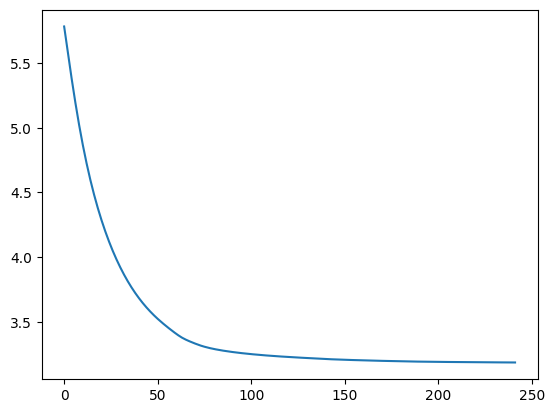

In [11]:
gae.plot()

In [12]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [13]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [14]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [15]:
obs_df = adata.obs.dropna()

In [16]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.2342479322056272


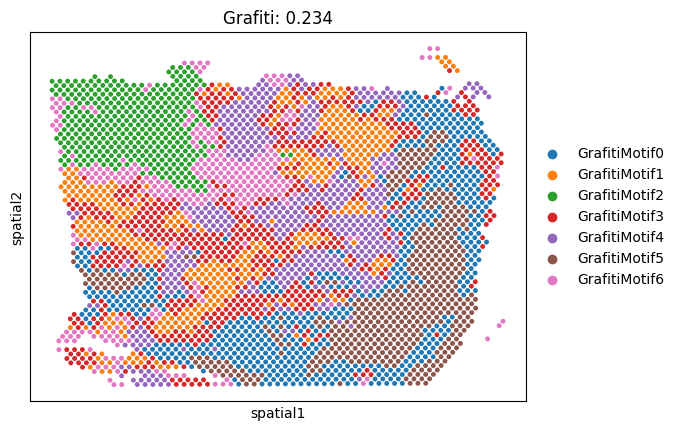

In [17]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

Text(0.5, 1.0, 'Spatial Distances DLPFC')

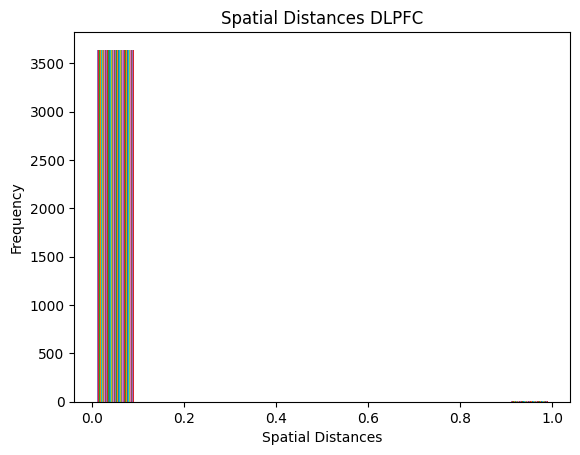

In [18]:
plt.hist(adata.obsp['spatial_distances'].toarray())
plt.xlabel('Spatial Distances')
plt.ylabel('Frequency')
plt.title('Spatial Distances DLPFC')